# Kr analysis (run 3379)

In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import numpy as np
import tables as tb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Fri Mar 31 15:50:18 2017


#### General plotting options

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/run3379ShortZ/"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()

def covariance(x, y):
    cov = np.cov(x, y)
    l, v = np.linalg.eig(cov)
    lx, ly = l**0.5
    vx, vy = v.T
    x0, y0 = np.mean(x), np.mean(y)
    x1     = lx * vx[0]
    y1     = lx * vx[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*ly, head_length=0.1*lx, fc='r', ec='r')
    x1     = ly * vy[0]
    y1     = ly * vy[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*lx, head_length=0.1*ly, fc='r', ec='r')
    return l, v

def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (41.5/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*f.values[1:], *reso(f.values)))

def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

save = functools.partial(save_to_folder, outputfolder)

### Input data

In [4]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = os.environ["IC_DATA"] + "/Kr2016/data/3379/"

pattern = "$IC_DATA/*.h5"
ifiles  = glob.glob(os.path.expandvars(pattern))

print("# files:", len(ifiles))

# files: 2175


### Define event class

In [5]:
class Event:
    """
    Store for relevant event info.
    """
    def __init__(self):
        self.nS1   = 0
        self.S1w   = []
        self.S1h   = []
        self.S1i   = []
        self.S1t   = []

        self.nS2   = 0
        self.S2w   = []
        self.S2h   = []
        self.S2i   = []

        self.Nsipm = []
        self.Q     = []
        self.Qsipm = []
        self.Xt    = np.nan
        self.Yt    = np.nan
        self.X     = np.nan
        self.Y     = np.nan
        self.Xrms  = np.nan
        self.Yrms  = np.nan
        self.Z     = np.nan
        self.R     = np.nan
        self.Phi   = np.nan

        self.T     = -1
        self.ok    = False

### Define dataset class

In [6]:
class Dataset:
    """
    Trick for accesing event properties as an attribute of the dataset.
    """
    def __init__(self, evts):
        self.evts = np.array(evts, dtype=object)
        self._create_attrs()
    
    @timefunc
    def _create_attrs(self):
        for attr in filter(lambda x: not x.endswith("__"), Event().__dict__):
            setattr(self, attr, np.array([getattr(evt, attr) for evt in self.evts]))

    def __getitem__(self, sel):
        return Dataset(self.evts[sel])

## Functions to fill the event and dataset classes

In [7]:
#@timefunc
def fill_evts(s1s, s2s, sis, evts_out, times, ifile=None):    
    evts = set(list(s1s.keys()) +
               list(s2s.keys()) +
               list(sis.keys()))
    nevt = len(evts)
    #print(ifile, nevt)
    for i, evt_number in enumerate(evts):
        evt = Event()
        s1  = s1s.get(evt_number, dict())
        s2  = s2s.get(evt_number, dict())
        si  = sis.get(evt_number, dict())
        
        evt.nS1 = 0
        evt.nS2 = len(s2)

        s1time = 0
        for peak, (t, e) in s1.items():
            sel  = e > 0.5
            t, e = t[sel], e[sel]
            if t.size < 5:
                continue
            evt.nS1 += 1
            evt.S1w.append(width(t))
            evt.S1h.append(np.max(e))
            evt.S1i.append(np.sum(e))
            s1time = t[np.argmax(e)]
            evt.S1t.append(s1time)
        
        s2time = 0
        for peak, (t, e) in s2.items():
            evt.S2w.append(width(t, to_mus=True))
            evt.S2h.append(np.max(e))
            evt.S2i.append(np.sum(e))
            s2time = t[np.argmax(e)]

            IDs, Qs = integrate_charge(si[peak]) if peak in si else ([], [])
            Qpeak   = np.sum(Qs)
            xsipms  = DataSiPM.X.values[IDs]
            ysipms  = DataSiPM.Y.values[IDs]

            evt.Qsipm.append(Qs)
            evt.Nsipm.append(len(IDs))
            evt.Q    .append(Qpeak)
            evt.X    = np.average(xsipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Y    = np.average(ysipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Xrms = (np.sum(Qs * (xsipms-evt.X)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.Yrms = (np.sum(Qs * (ysipms-evt.Y)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.R    = (evt.X**2 + evt.Y**2)**0.5 if np.any(Qs) else np.nan
            evt.Phi  = np.arctan2(evt.Y, evt.X) if np.any(Qs) else np.nan

        evt.T  = times[i]
        evt.ok = evt.nS1 == evt.nS2 == 1
        if evt.ok:
            evt.Z = (s2time - s1time) * units.ns / units.mus
        evts_out.append(evt)


@timefunc
def build_dataset(inputfiles):
    evts_out = []
    first    = True
    for ifile in inputfiles:
        s1s, s2s, sis = pmapf.read_pmaps(ifile)
        with tb.open_file(ifile) as h5f:
            times = h5f.root.Run.events.cols.timestamp[:] * 1e-3
        if first:
            t0 = np.min(times)
            first = False
            print("First event at t = {} s".format(t0))
        fill_evts(pmapf.df_to_pmaps_dict(s1s),
                  pmapf.df_to_pmaps_dict(s2s),
                  pmapf.df_to_s2si_dict (sis),
                  evts_out, times - t0, ifile)
    return Dataset(evts_out)


# Read data

In [8]:
full = build_dataset(ifiles)#[:1500])

First event at t = 1490211059.618 s
Time spent in _create_attrs: 10.33918809890747 s
Time spent in build_dataset: 391.190603017807 s


## General plots (no selections applied)

First event t:  0.0
Last  event t:  47266.711
Trigger rate: 7.546537350573411 evts/s


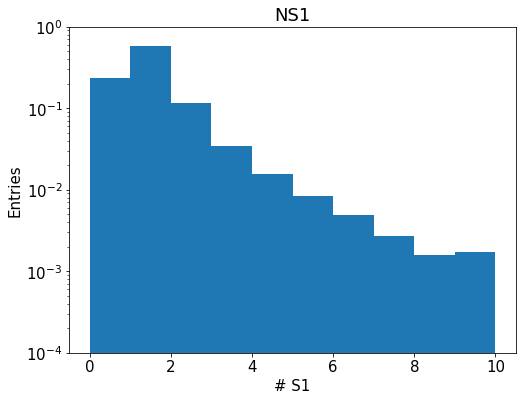

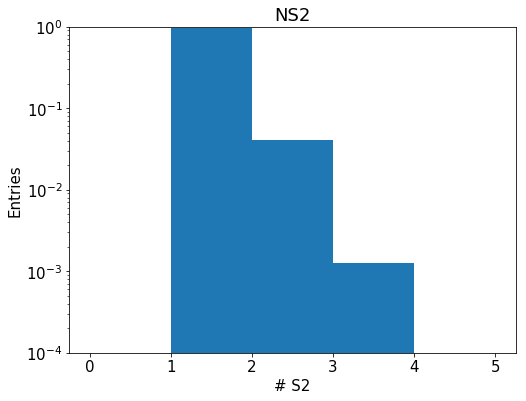

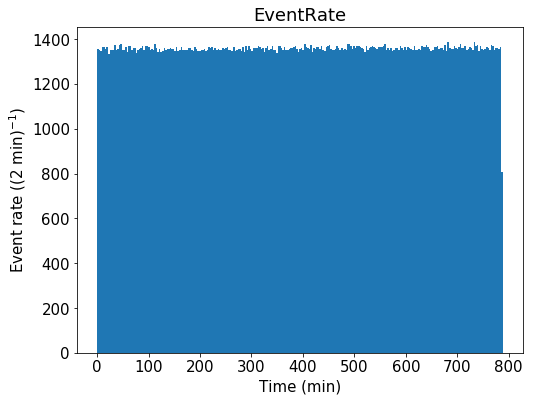

In [9]:
data = full

################################
pdf(data.nS1, 10, range=(0, 10))
labels("# S1", "Entries")
save("NS1")

################################
pdf(data.nS2,  5, range=(0, 5))
labels("# S2", "Entries")
save("NS2")

################################
T    = data.T / 60
nmin = 0
tmax = 0
nbin = 1e12
while nbin > 300:
    nmin += 1
    T    *= nmin / (nmin + 1)
    nbin  = int(math.ceil(np.max(T)))
    tmax  = nbin * (nmin + 1)

Trange = 0, tmax
hist(data.T / 60, np.linspace(0, tmax, nbin+1))
labels("Time (min)", "Event rate (({} min)$^{{-1}}$)".format(nmin))
save("EventRate")

t0 = np.min(data.T)
t1 = np.max(data.T)
print("First event t: ", t0)
print("Last  event t: ", t1)
print("Trigger rate: {} evts/s".format(full.evts.size/(t1-t0)))

## From now on the study is focused on those events with exactly one S1 and one S2

In [10]:
oneS1oneS2 = full[full.ok]
print("Full set   :",       full.evts.size, "events")
print("Reduced set:", oneS1oneS2.evts.size, "events")
print("Ratio      :", oneS1oneS2.evts.size/full.evts.size)

Time spent in _create_attrs: 6.133044958114624 s
Full set   : 356700 events
Reduced set: 198945 events
Ratio      : 0.5577375946173255


<b>
The ratio of "reliable" to total events is ~51.2%
</b>

# Distribution of events in Z

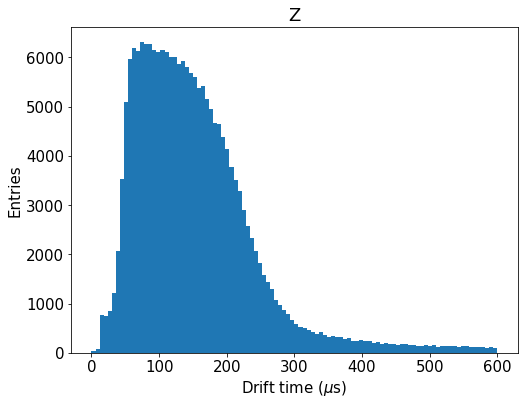

In [11]:
data = oneS1oneS2

hist(data.Z, 100, (0, 600))
labels("Drift time ($\mu$s)", "Entries")
save("Z")

<b>
Looks like there is an accumulation of events for Z < 200 $\mu$s and a flat distribution for Z > 200 $\mu$s.
</b>

# S2 energy vs Z

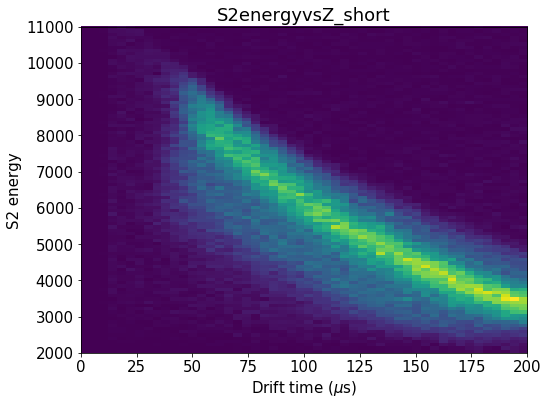

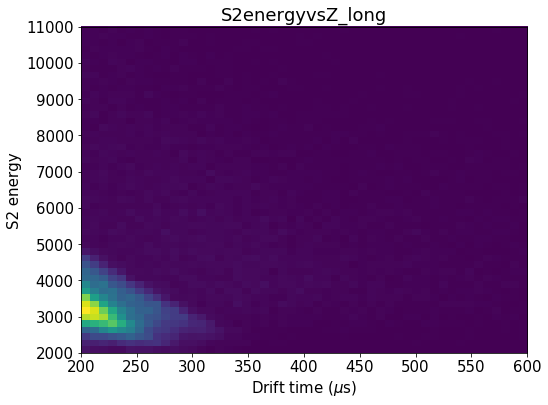

In [12]:
data = oneS1oneS2

zrange =   0, 200
Erange = 2e3, 11e3
hist2d(data.Z, flat(data.S2i), (50, 100), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_short")

zrange = 200, 600
Erange = 2e3, 11e3
hist2d(data.Z, flat(data.S2i), (50,  50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_long")

# Short drift time: Z < 200 $\mu$s

In [13]:
shortZ = oneS1oneS2[oneS1oneS2.Z < 200]

Time spent in _create_attrs: 4.513215065002441 s


# S1 energy

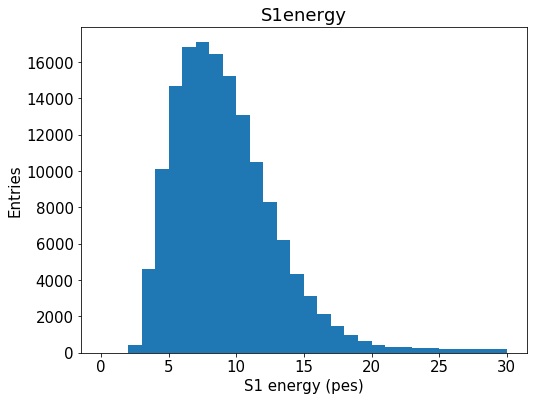

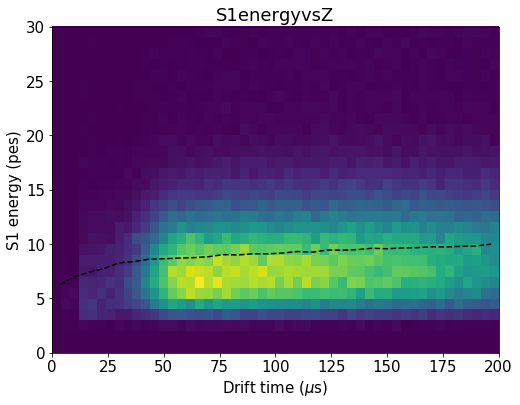

In [14]:
data = shortZ

zrange = 0, 200
Srange = 0, 30

s1i = flat(data.S1i)

hist(s1i, 30, range=Srange)
labels("S1 energy (pes)", "Entries")
save("S1energy")

hist2d(data.Z, s1i, (50, 30), range=(zrange, Srange))
x, y, _ = fitf.profileX(data.Z, s1i, 30, xrange=zrange, yrange=Srange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1energyvsZ")

# S1 width

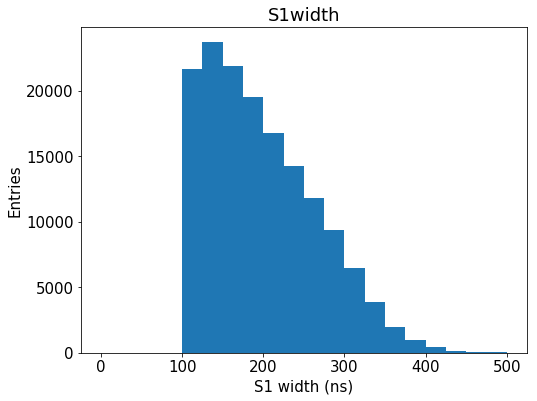

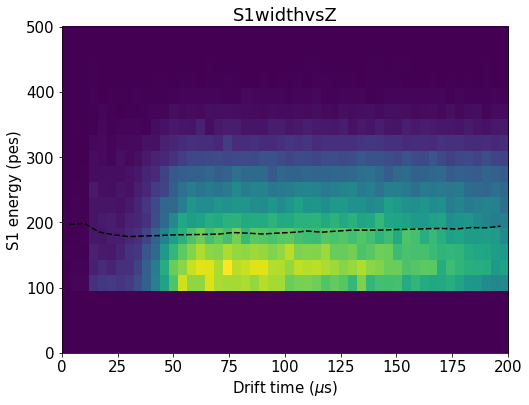

In [15]:
data = shortZ

zrange = 0, 200
wrange = 0, 500

s1w = flat(data.S1w)

hist(s1w, np.linspace(*wrange, 21))
labels("S1 width (ns)", "Entries")
save("S1width")

hist2d(data.Z, s1w, (50, 21), range=(zrange, wrange))
x, y, _ = fitf.profileX(data.Z, s1w, 30, xrange=zrange, yrange=wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1widthvsZ")

# S1 height

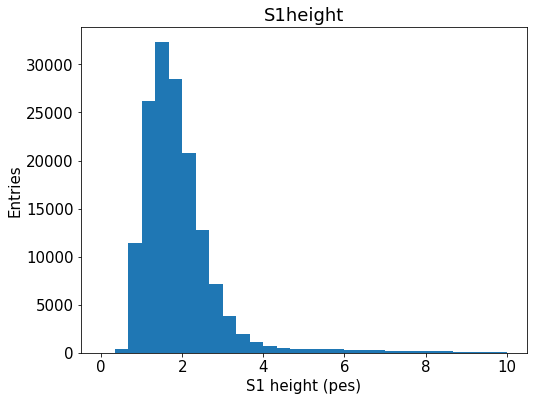

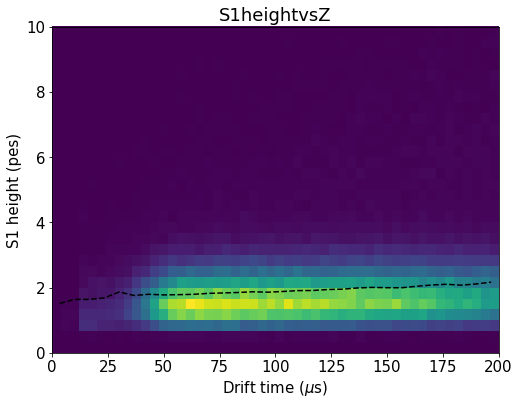

In [16]:
data = shortZ

zrange = 0, 200
hrange = 0, 10

s1h = flat(data.S1h)

hist(s1h, 30, range=hrange)
labels("S1 height (pes)", "Entries")
save("S1height")

hist2d(data.Z, s1h, (50, 30), range=(zrange, hrange))
x, y, _ = fitf.profileX(data.Z, s1h, 30, xrange=zrange, yrange=hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 height (pes)")
save("S1heightvsZ")

# S1 peak to area ratio

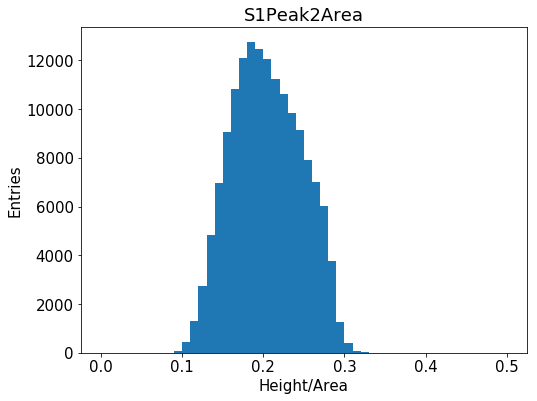

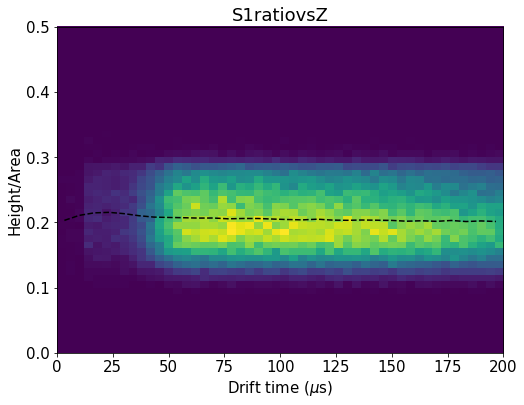

In [17]:
data = shortZ

zrange = 0, 200
rrange = 0, 0.5

s1r = flat(data.S1h)/flat(data.S1i)

hist(s1r, 50, range=rrange)
labels("Height/Area", "Entries")
save("S1Peak2Area")

hist2d(data.Z, s1r, (50, 50), range=(zrange, rrange))
x, y, _ = fitf.profileX(data.Z, s1r, 30, xrange=zrange, yrange=rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area")
save("S1ratiovsZ")

# S2 energy

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


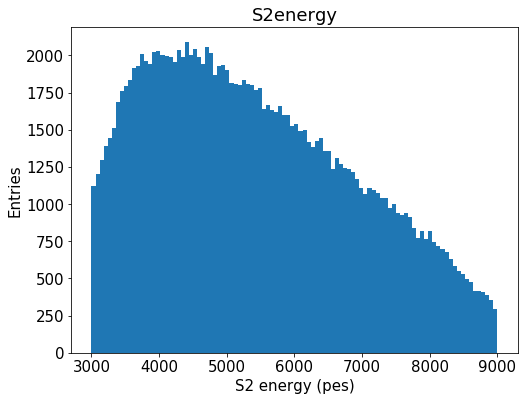

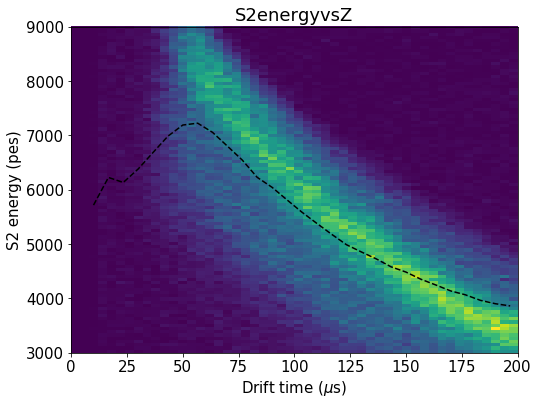

In [18]:
data = shortZ

zrange = 0, 200
Erange = 3e3, 9e3

s2i = flat(data.S2i)

hist(s2i, 100, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy")

hist2d(data.Z, s2i, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(data.Z, s2i, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")

# S2 width

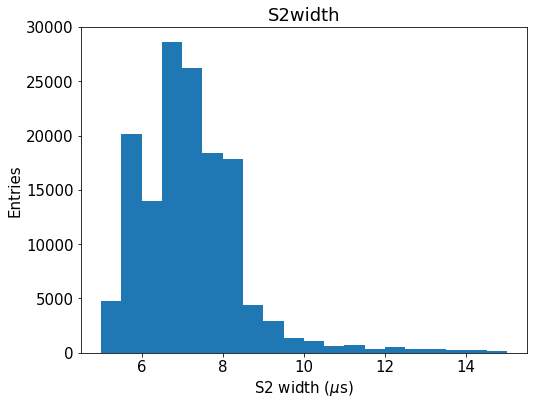

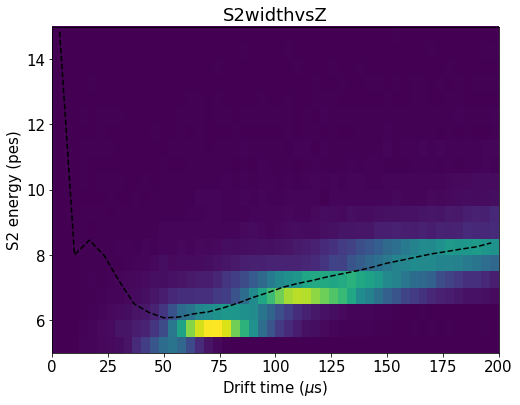

In [19]:
data = shortZ

zrange = 0, 200
wrange = 5, 15

s2w = flat(data.S2w)

hist(s2w, 20, range=wrange)
labels("S2 width ($\mu$s)", "Entries")
save("S2width")

hist2d(data.Z, s2w, (50, 20), range=(zrange, wrange))
x, y, _ = fitf.profileX(data.Z, s2w, 30, xrange=zrange, yrange=wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2widthvsZ")

# S2 height

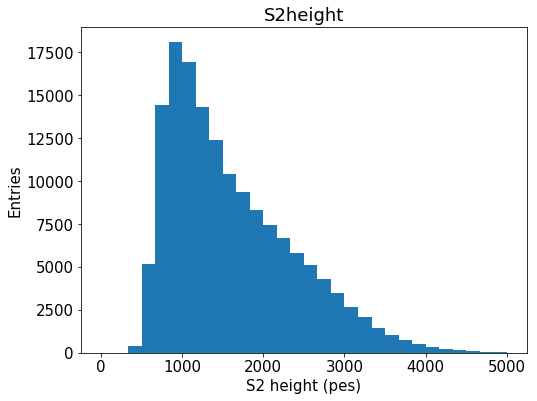

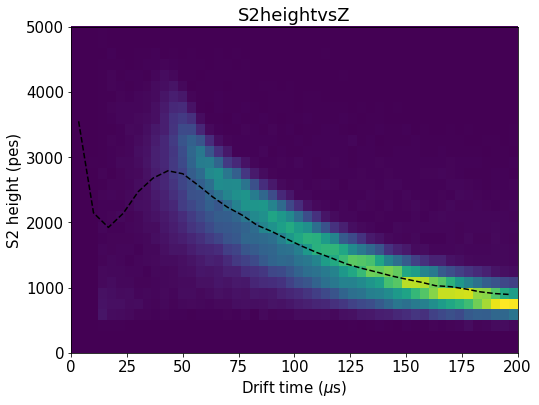

In [20]:
data = shortZ

zrange = 0, 200
hrange = 0, 5e3

s2h = flat(data.S2h)

hist(s2h, 30, range=hrange)
labels("S2 height (pes)", "Entries")
save("S2height")

hist2d(data.Z, s2h, (50, 30), range=(zrange, hrange))
x, y, _ = fitf.profileX(data.Z, s2h, 30, xrange=zrange, yrange=hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

# S2 peak to area ratio

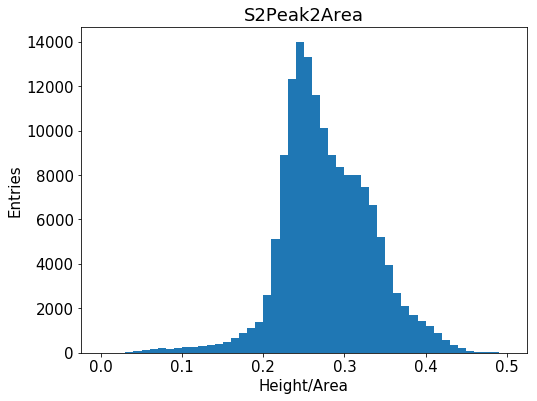

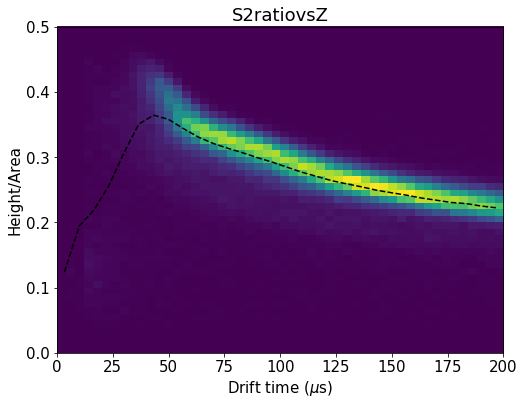

In [21]:
data = shortZ

zrange = 0, 200
rrange = 0, 0.5

s2r = flat(data.S2h)/flat(data.S2i)

hist(s2r, 50, range=rrange)
labels("Height/Area", "Entries")
save("S2Peak2Area")

hist2d(data.Z, s2r, (50, 50), range=(zrange, rrange))
x, y, _ = fitf.profileX(data.Z, s2r, 30, xrange=zrange, yrange=rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area")
save("S2ratiovsZ")

# S2 vs S1

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[  1.09810017e+01   2.24395319e+06] [[ -9.99999986e-01   1.68221620e-04]
 [ -1.68221620e-04  -9.99999986e-01]]


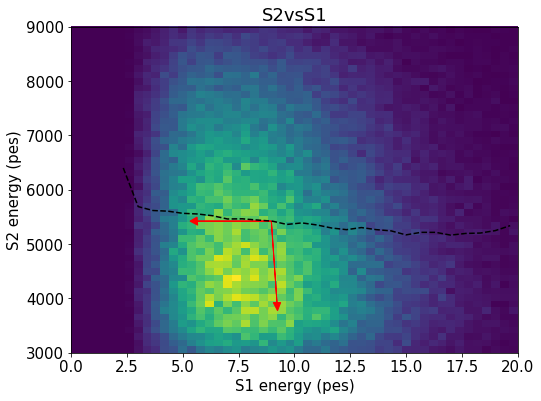

In [22]:
data = shortZ

Srange = 0, 20
Erange = 3e3, 9e3

S = flat(data.S1i)
E = flat(data.S2i)

hist2d(S, E, (50, 50), range=(Srange, Erange))
x, y, _ = fitf.profileX(S, E, 30, xrange=Srange, yrange=Erange)
plt.plot(x, y, profOpt)

sel = fitf.in_range(S, *Srange) & fitf.in_range(E, *Erange)
c = covariance(S[sel], E[sel])
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")

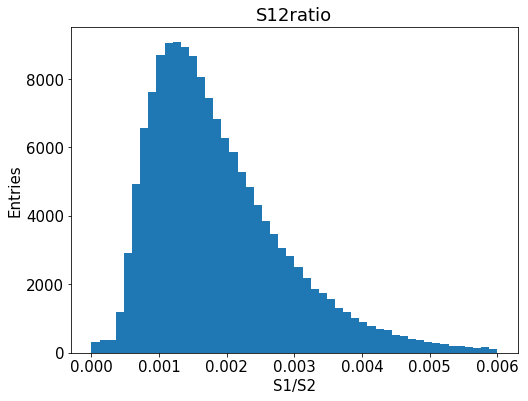

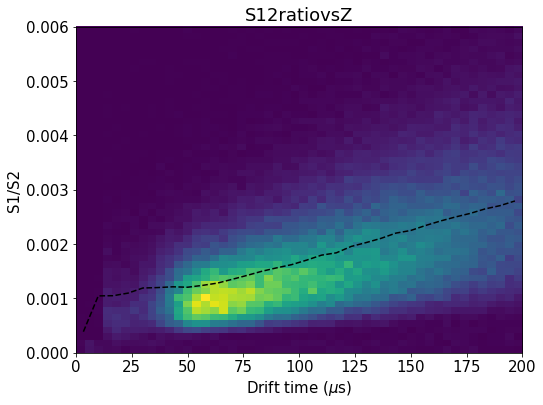

In [23]:
data = shortZ

zrange = 0, 200
Rrange = 0, 0.006

R = flat(data.S1i)/flat(data.S2i)

hist(R, 50, range=Rrange)
labels("S1/S2", "Entries")
save("S12ratio")

hist2d(data.Z, R, (50, 50), range=(zrange, Rrange))
x, y, _ = fitf.profileX(data.Z, R, 30, xrange=zrange, yrange=Rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2")
save("S12ratiovsZ")

# Temporary fiducialization

In [24]:
fiducialized = shortZ[shortZ.R < 100]

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


Time spent in _create_attrs: 1.107668161392212 s


# S2 energy fiducialized

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ 11780.24171355   -172.52930521]


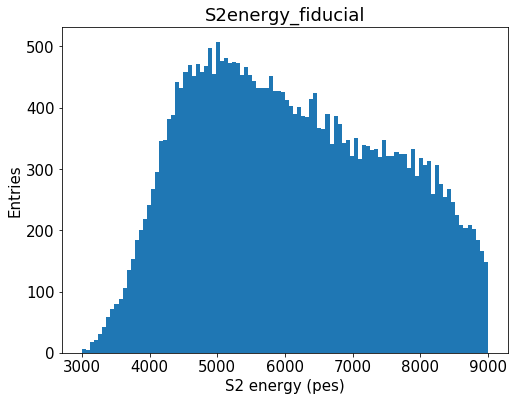

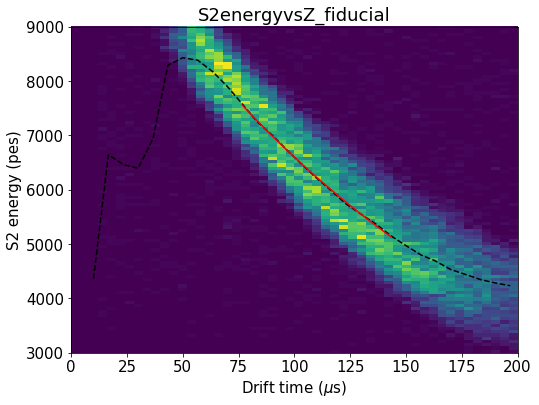

In [25]:
data = fiducialized

zrange = 0, 200
Erange = 3e3, 9e3

s2i = flat(data.S2i)

hist(s2i, 100, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy_fiducial")

hist2d(data.Z, s2i, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(data.Z, s2i, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 75, 150)
x, y = x[sel], y[sel]

f = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ_fiducial")

zfun  = f.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)

# Correction by attachment

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ 7681.13630074 -5703.53225145]


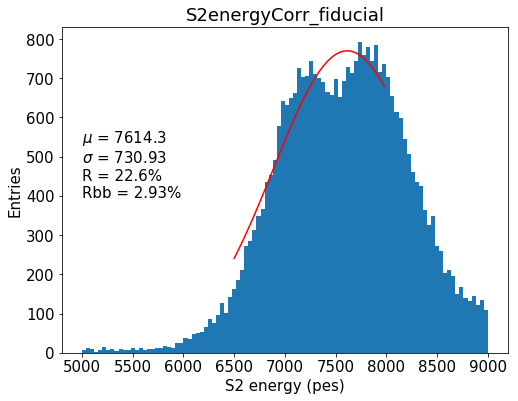

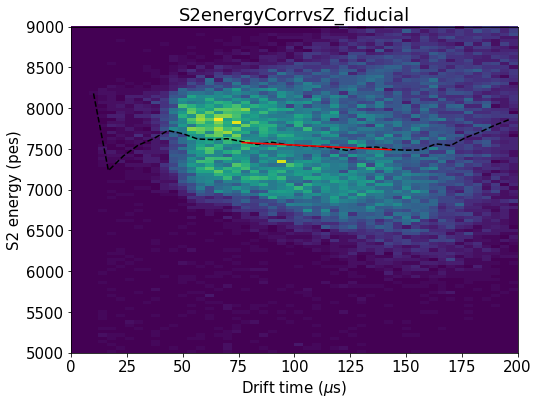

In [26]:
data = fiducialized

zrange = 0, 200
Erange = 5e3, 9e3

s2i = flat(data.S2i) * zcorr(data.Z)

y, x, _ = hist(s2i, 100, range=Erange)

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 6500, 8000)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 7e3, 200))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("S2 energy (pes)", "Entries")
save("S2energyCorr_fiducial")

hist2d(data.Z, s2i, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(data.Z, s2i, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 75, 150)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)

print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyCorrvsZ_fiducial")

# Tracking

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


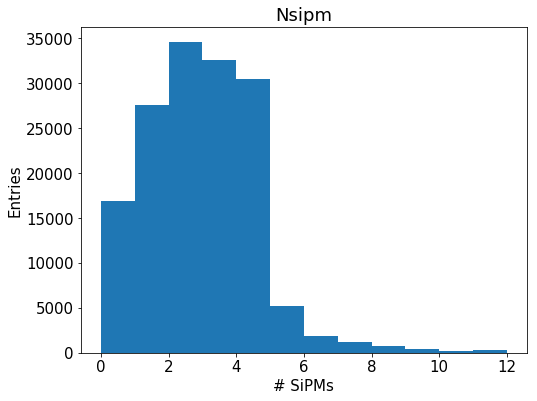

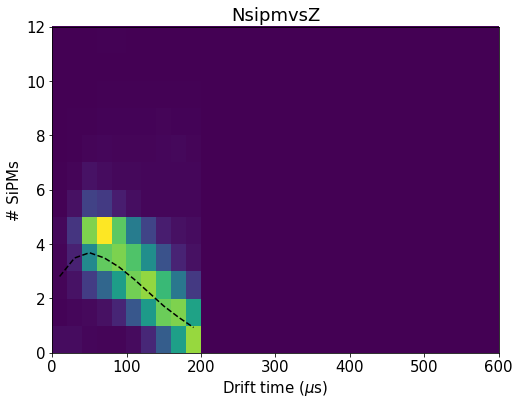

In [27]:
data = shortZ

nrange = 0, 12
zrange = 0, 600

nsipm = flat(data.Nsipm)

hist(nsipm, max(nrange), nrange)
labels("# SiPMs", "Entries")
save("Nsipm")

hist2d(data.Z, nsipm, (30, max(nrange)), range=(zrange, nrange))
x, y, _ = fitf.profileX(data.Z, nsipm, 30, xrange=zrange, yrange=nrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs")
save("NsipmvsZ")


# Take events with > 2 sipms, acceptable S2 energy and fiducialized to 180 mm

In [28]:
spread = shortZ[(flat(shortZ.Nsipm) > 1) & (flat(shortZ.S2i) < 9000) & (flat(shortZ.R) < 180)]

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


Time spent in _create_attrs: 2.907711982727051 s


# Event distribution

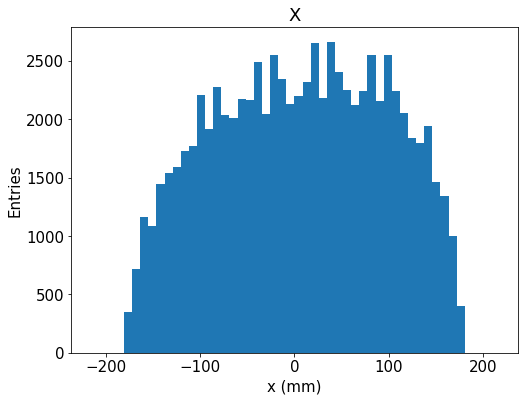

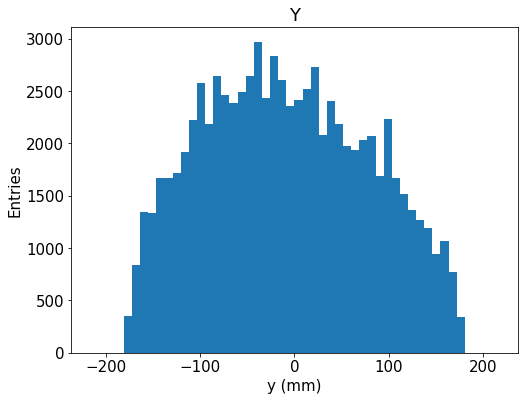

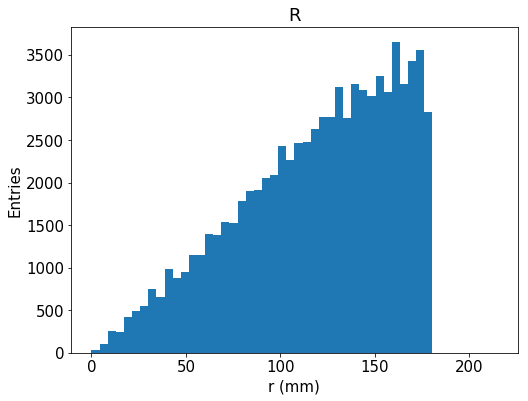

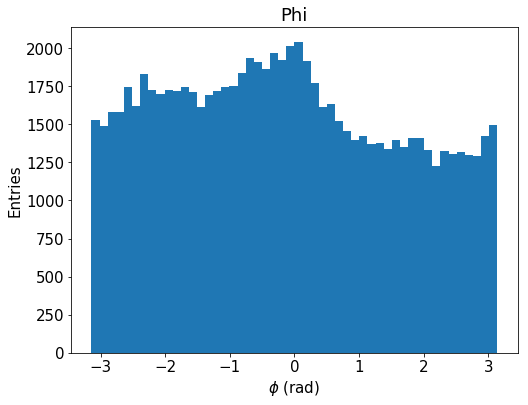

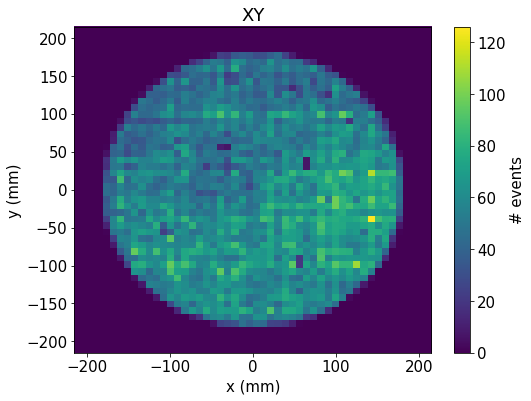

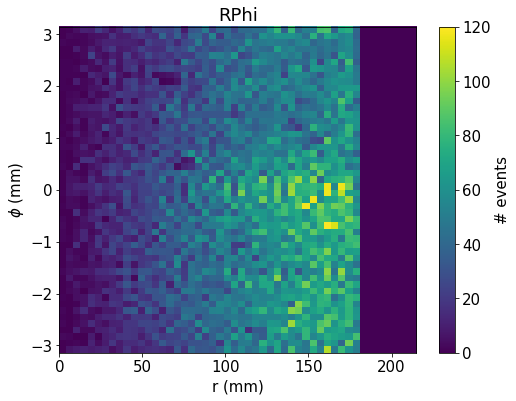

In [29]:
data = spread

xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(data.X, 50, range=xrange)
labels("x (mm)", "Entries")
save("X")

hist(data.Y, 50, range=yrange)
labels("y (mm)", "Entries")
save("Y")

hist(data.R, 50, range=rrange)
labels("r (mm)", "Entries")
save("R")

hist(data.Phi, 50, range=prange)
labels("$\phi$ (rad)", "Entries")
save("Phi")

nevts, xs, ys, _ = \
hist2d(data.X, data.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")
save("XY")

################################
hist2d(data.R, data.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

def stat_corr(xs, ys, ns):
    xs = xs.reshape(xs.size, 1)
    ys = ys.reshape(ys.size, 1)
    def correct(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        n = ns[x_closest, y_closest]
        n[n==0] = np.nan
        return n
    return correct
statcorr = stat_corr(xs[:-1], ys[:-1], nevts)


# Tracking charge

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


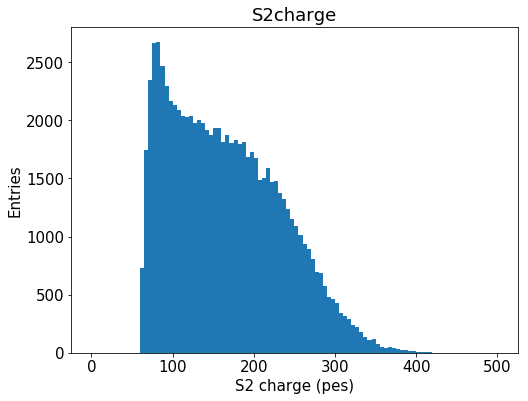

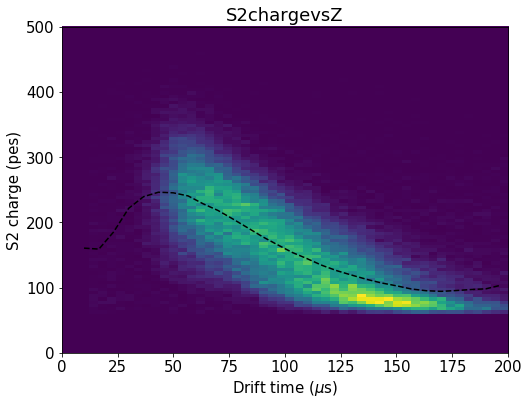

In [30]:
data = spread

zrange = 0, 200
Qrange = 0, 500

s2q = flat(data.Q)

hist(s2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries")
save("S2charge")

hist2d(data.Z, s2q, (50, 100), range=(zrange, Qrange))
x, y, _ = fitf.profileX(data.Z, s2q, 30, xrange=zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)")
save("S2chargevsZ")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


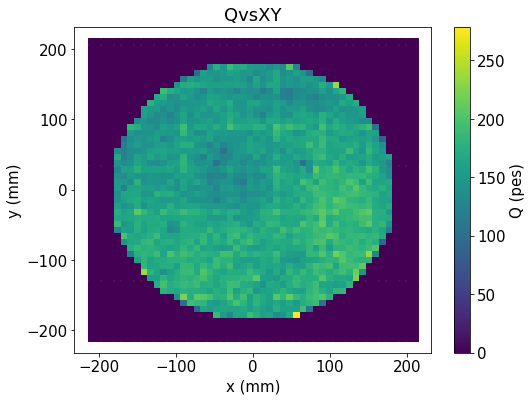

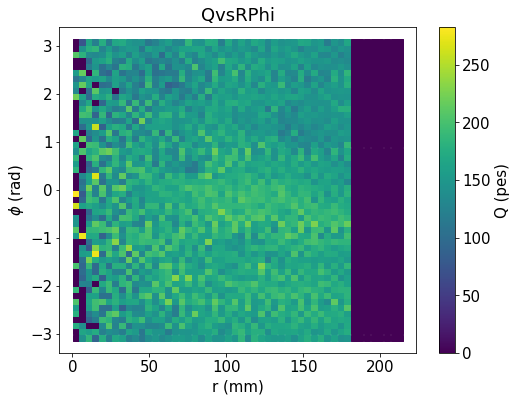

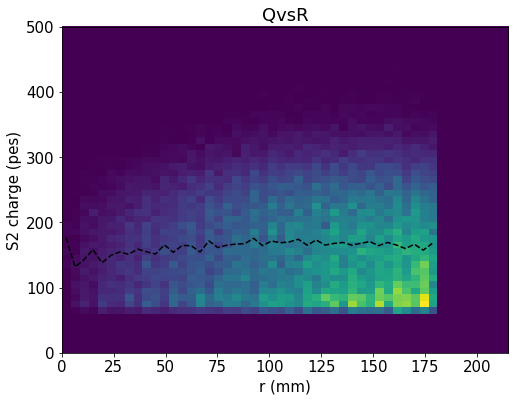

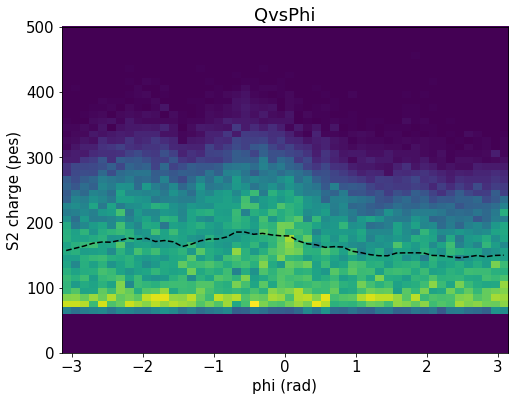

In [31]:
data = spread
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Qrange =    0, 500

Q  = flat(data.Q)
#Qw = Q/statcorr(data.X, data.Y)
#hist2d(data.X, data.Y, (50, 50), range=(xrange, yrange), weights=Qw, cmax=Qrange[1])
_, _, cb = profile_and_scatter(data.X, data.Y, Q, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)")
save("QvsXY")

#hist2d(data.R, data.Phi, (50, 50), range=(rrange, prange), weights=Qw, cmax=Qrange[1])
_, _, cb = profile_and_scatter(data.R, data.Phi, Q, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("QvsRPhi")

hist2d(data.R, Q, (50, 50), range=(rrange, Qrange))
x, y, _ = fitf.profileX(data.R, Q, 50, xrange=rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)")
save("QvsR")

hist2d(data.Phi, Q, (50, 50), range=(prange, Qrange))
x, y, _ = fitf.profileX(data.Phi, Q, 50, xrange=prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)")
save("QvsPhi")


# Energy vs position

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


7551.54381975


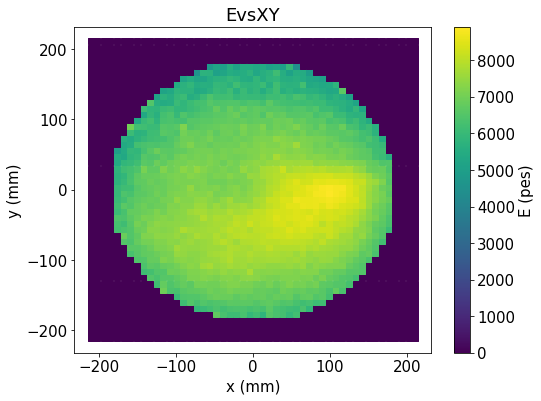

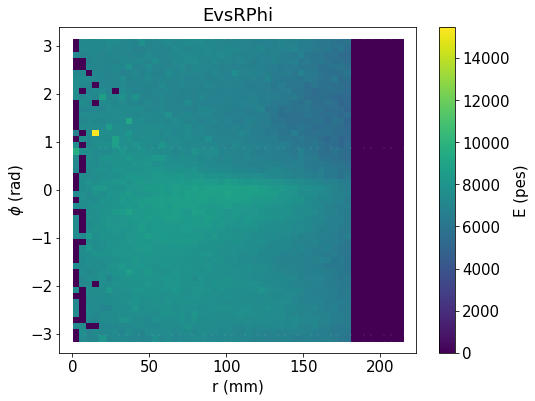

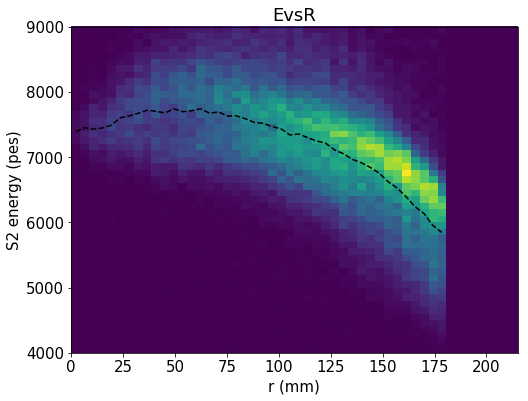

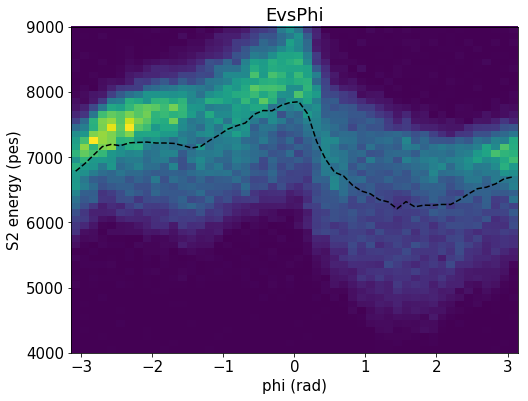

In [32]:
data   = spread
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 9e3

E  = flat(data.S2i) * zcorr(data.Z)
Ew = E / statcorr(data.X, data.Y)

#Es, xs, ys, _ = \
#hist2d(data.X, data.Y, (50, 50), range=(xrange, yrange), weights=Ew, cmax=Erange[1])
#plt.colorbar()
pf, _, cb = profile_and_scatter(data.X, data.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

#hist2d(data.R, data.Phi, (50, 50), range=(rrange, prange), weights=Ew, cmax=Erange[1])
_, _, cb = profile_and_scatter(data.R, data.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(data.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(data.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(data.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(data.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])


# Correction by attachment and position

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


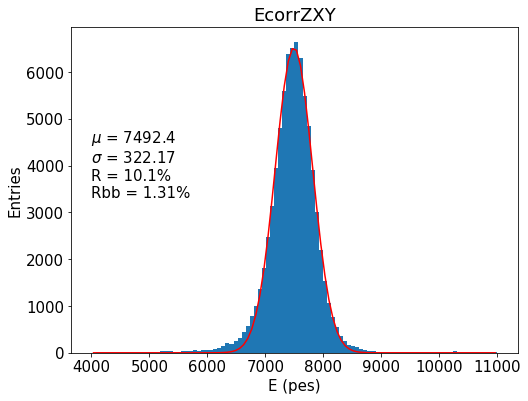

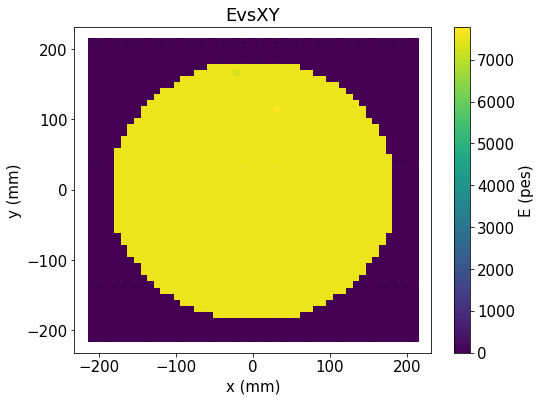

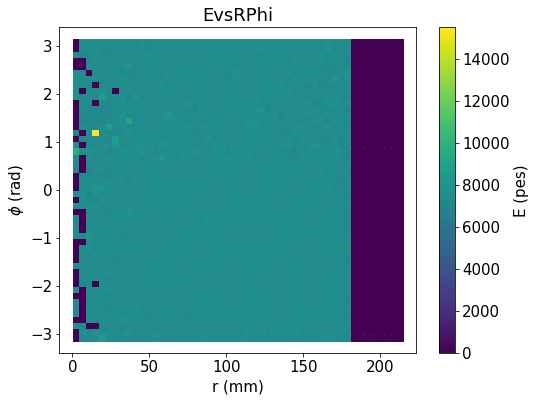

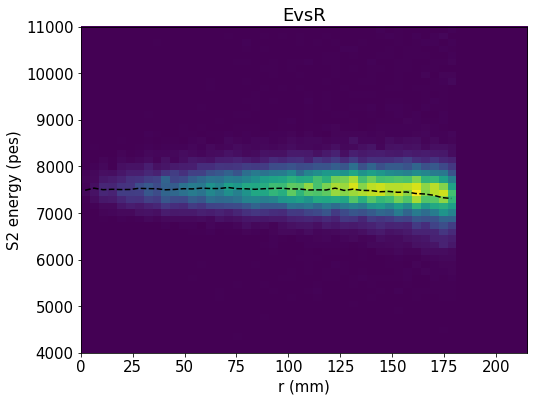

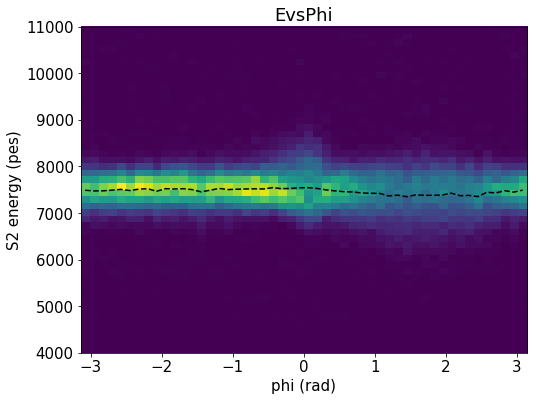

In [33]:
data   = spread
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 11e3

E  = flat(data.S2i) * zcorr(data.Z) * xycorr(data.X, data.Y)
Ew = E / statcorr(data.X, data.Y)

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXY")

_, _, cb = profile_and_scatter(data.X, data.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(data.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(data.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(data.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(data.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")


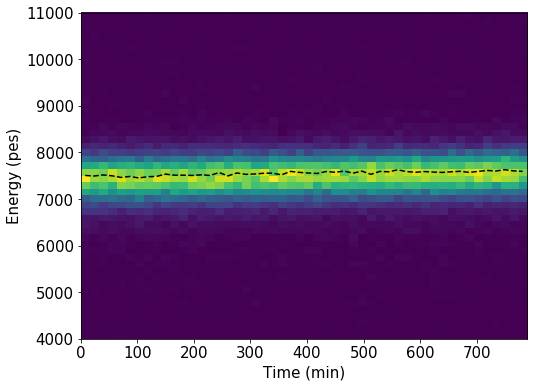

In [34]:
data   = spread
E      = flat(data.S2i) * zcorr(data.Z) * xycorr(data.X, data.Y)

Erange = 4e3, 11e3

T = data.T/60

hist2d(T, E, (50, 50), range=(Trange, Erange))

x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")

def get_timecorr(T, E):
    eref = np.max(E)
    def timecorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return timecorr
tcorr = get_timecorr(x, y)

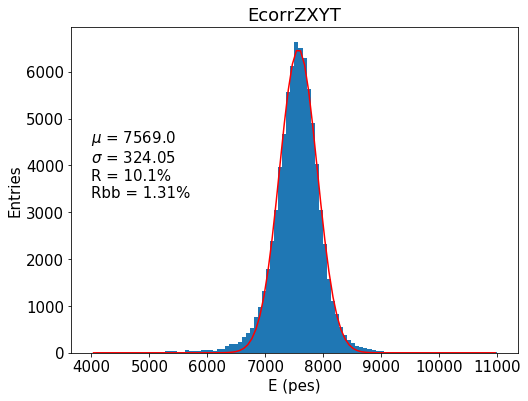

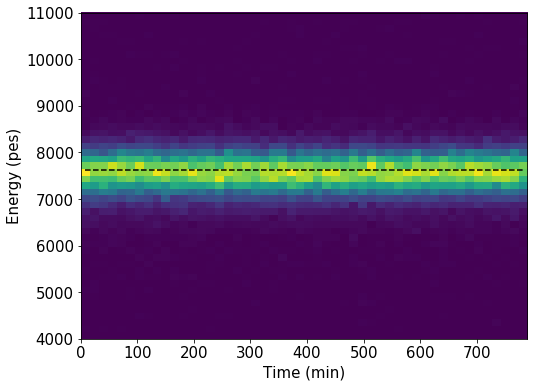

In [35]:
data   = spread
E      = flat(data.S2i) * zcorr(data.Z) * xycorr(data.X, data.Y) * tcorr(data.T/60)

Erange = 4e3, 11e3

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXYT")

T = data.T/60

hist2d(T, E, (50, 50), range=(Trange, Erange))
x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")
